## Experiment Setting: On the impact of features orthogonality for Link Representation Learning with Message Passing Neural Network(MPNN)
This experiment aims to analyze the capacity of MPNNs to capture structural features under varying configurations, including the type of MPNN, the node features employed, and the choice of dataset. 


## Trial 1

1. Simplified MPNN: is a mapping from $f(\tilde{\mathbf{A}}, \mathbf{X}) \to \mathbf{H}$, $\text{softmax}(\text{Act}((\mathbf{\tilde{A}XW^0)W^1}))$.
    - $\mathbf{h_i} \in \mathbb{R}^{n \times d}$, embedding of vertex $i$, $n$: number of vertex, $d$ number of dimension.
    - $\mathbf{X}$: initial node features
    - $\mathbf{H}^*$: optimized node embedding w.r.t. all $\mathbf{W}$
    - $\text{Act}$: Activation function, mostly nonlinear and [ReLU](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)). 
    
2. Loss function in LP: $\min_{H^*}  \underbrace{\sum_{(i,j) \in E_\text{pos}} \left(1 - \sigma(h_i, h_j)^\top \right)}_{\text{positive samples}} - \underbrace{\sum_{(i,j) \in E_{\text{neg}}} \left(\sigma(h_i, h_j)^\top \right)}_{\text{negative samples}}$ 

3. Custom Loss for Common Neighbor Regression Task: $\min_{H^*}  \underbrace{\sum_{(i,j) \in E_\text{pos}} \Vert 1 - \sigma(h_i, h_j)^\top \Vert_2^2}_{\text{positive samples}} + \underbrace{\sum_{(i,j) \in E_{\text{neg}}} \Vert (0 - \sigma(h_i, h_j)^\top \Vert)_2^2}_{\text{negative samples}}$ 



In [3]:
import pandas as pd
root = '/pfs/work7/workspace/scratch/cc7738-kdd25/Universal-MP/'
# Load the data
file_path = root + 'trials/results/Custom_GAT2CN_ddi.csv'
data = pd.read_csv(file_path)

# Calculate the mean and variance of 'Test_Loss' for rows with the same 'Model' and 'NodeFeat'
merged_data = data.groupby(['Model', 'NodeFeat', 'Heuristic']).agg(
    Mean_Loss=('Test_Loss', 'mean'),
    Variance_Loss=('Test_Loss', 'var')
).reset_index()

# Display the processed data (or save it if needed)
data = merged_data['Mean_Loss'] 
errors = merged_data['Variance_Loss']
merged_data

,Model,NodeFeat,Heuristic,Mean_Loss,Variance_Loss
0,Custom_GAT,adjacency,CN,0.017952,6.800000e-04
1,Custom_GAT,one-hot,CN,0.031190,3.032790e-05
2,Custom_GAT,original,CN,0.062848,2.082773e-05
3,Custom_GAT,random,CN,0.020672,5.196997e-04
4,Custom_GCN,adjacency,CN,0.068256,1.854625e-05
5,Custom_GCN,one-hot,CN,0.012729,2.328791e-06
6,Custom_GCN,original,CN,0.064829,2.941838e-05
7,Custom_GCN,random,CN,0.004959,2.676361e-07
8,Custom_GIN,adjacency,CN,0.067639,1.837657e-05
9,Custom_GIN,one-hot,CN,0.067034,7.799333e-06


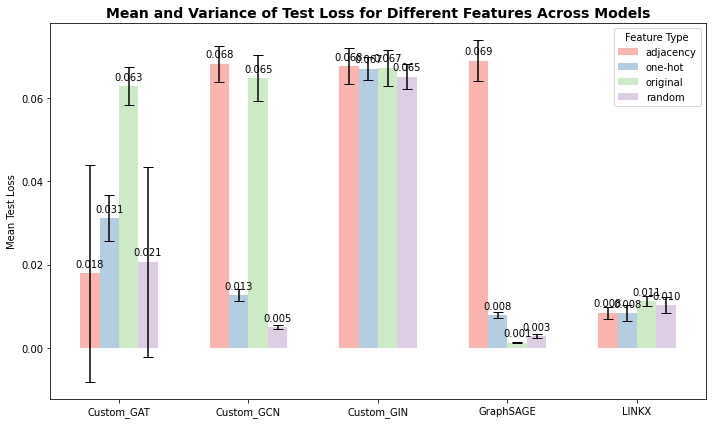

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Data values from the merged statistics
df = merged_data
# Plot settings
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(df["Model"].unique()))  # x-axis positions for each method
width = 0.15  # Adjusted width for additional feature type

colors = ['#fbb4ae', '#b3cde3', '#ccebc5', '#decbe4', '#fed9a6']  # Soft pastel shades

# Extract unique features and methods for grouping
unique_features = df["NodeFeat"].unique()
methods = df["Model"].unique()

complete_index = pd.MultiIndex.from_product([methods, unique_features], names=["Model", "NodeFeat"])
df = df.set_index(["Model", "NodeFeat"]).reindex(complete_index, fill_value=0).reset_index()

# Plot each feature's data for all models grouped by model type
for i, feature in enumerate(unique_features):
    feature_data = df[df["NodeFeat"] == feature]
    values = feature_data["Mean_Loss"].values
    errors = np.sqrt(feature_data["Variance_Loss"].values)  # Standard deviation for error bars

    # Plot bar with error bars
    ax.bar(x + i * width, values, width, yerr=errors, label=feature, color=colors[i], capsize=5)

    # Adding data labels for mean values
    for j, val in enumerate(values):
        ax.text(x[j] + i * width, val + 0.001, f'{val:.3f}', ha='center', va='bottom')

# Set labels and title
ax.set_ylabel('Mean Test Loss')
ax.set_title('Mean and Variance of Test Loss for Different Features Across Models', loc='center', fontsize=14, fontweight='bold')
ax.set_xticks(x + width * (len(unique_features) - 1) / 2)
ax.set_xticklabels(methods)
ax.legend(loc='upper right', title="Feature Type")


plt.tight_layout()
plt.show()


In [7]:
import pandas as pd

# Load the data
file_path = root + 'trials/results/Custom_GAT2PPR_ddi.csv'
data = pd.read_csv(file_path)

# Calculate the mean and variance of 'Test_Loss' for rows with the same 'Model' and 'NodeFeat'
merged_data = data.groupby(['Model', 'NodeFeat', 'Heuristic']).agg(
    Mean_Loss=('Test_Loss', 'mean'),
    Variance_Loss=('Test_Loss', 'var')
).reset_index()

# Display the processed data (or save it if needed)
data = merged_data['Mean_Loss'] 
errors = merged_data['Variance_Loss']
merged_data

,Model,NodeFeat,Heuristic,Mean_Loss,Variance_Loss
0,Custom_GAT,adjacency,PPR,0.000039,7.155487e-11
1,Custom_GAT,one-hot,PPR,0.000072,6.085679e-11
2,Custom_GAT,original,PPR,0.000031,1.100569e-10
3,Custom_GAT,random,PPR,0.000038,3.385581e-11
4,Custom_GCN,adjacency,PPR,0.000209,0.000000e+00
5,Custom_GCN,one-hot,PPR,0.000209,8.692586e-11
6,Custom_GCN,original,PPR,0.000110,9.638587e-10
7,Custom_GCN,random,PPR,0.001254,1.621503e-06
8,Custom_GIN,adjacency,PPR,0.000046,1.074199e-10
9,Custom_GIN,one-hot,PPR,0.000034,8.265117e-11


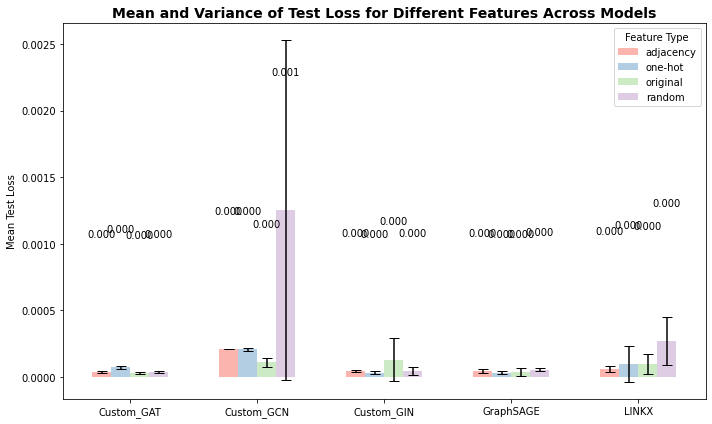

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Data values from the merged statistics
df = merged_data
# Plot settings
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(df["Model"].unique()))  # x-axis positions for each method
width = 0.15  # Adjusted width for additional feature type

colors = ['#fbb4ae', '#b3cde3', '#ccebc5', '#decbe4', '#fed9a6']  # Soft pastel shades

# Extract unique features and methods for grouping
unique_features = df["NodeFeat"].unique()
methods = df["Model"].unique()

complete_index = pd.MultiIndex.from_product([methods, unique_features], names=["Model", "NodeFeat"])
df = df.set_index(["Model", "NodeFeat"]).reindex(complete_index, fill_value=0).reset_index()

# Plot each feature's data for all models grouped by model type
for i, feature in enumerate(unique_features):
    feature_data = df[df["NodeFeat"] == feature]
    values = feature_data["Mean_Loss"].values
    errors = np.sqrt(feature_data["Variance_Loss"].values)  # Standard deviation for error bars

    # Plot bar with error bars
    ax.bar(x + i * width, values, width, yerr=errors, label=feature, color=colors[i], capsize=5)

    # Adding data labels for mean values
    for j, val in enumerate(values):
        ax.text(x[j] + i * width, val + 0.001, f'{val:.3f}', ha='center', va='bottom')

# Set labels and title
ax.set_ylabel('Mean Test Loss')
ax.set_title('Mean and Variance of Test Loss for Different Features Across Models', loc='center', fontsize=14, fontweight='bold')
ax.set_xticks(x + width * (len(unique_features) - 1) / 2)
ax.set_xticklabels(methods)
ax.legend(loc='upper right', title="Feature Type")


plt.tight_layout()
plt.show()


PPR

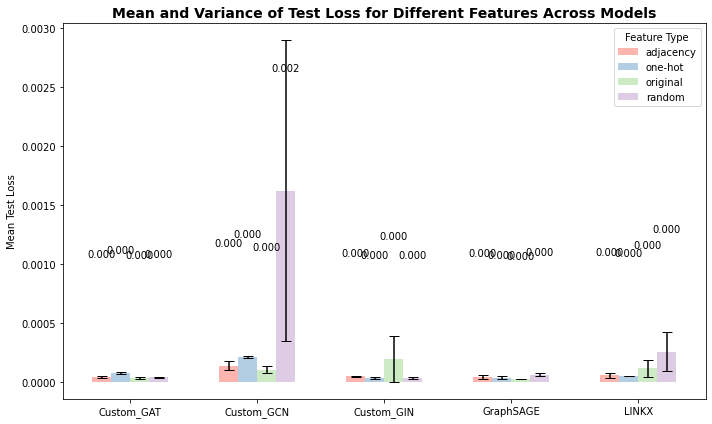

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Data values from the merged statistics
df = merged_data
# Plot settings
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(df["Model"].unique()))  # x-axis positions for each method
width = 0.15  # Adjusted width for additional feature type

colors = ['#fbb4ae', '#b3cde3', '#ccebc5', '#decbe4', '#fed9a6']  # Soft pastel shades

# Extract unique features and methods for grouping
unique_features = df["NodeFeat"].unique()
methods = df["Model"].unique()

complete_index = pd.MultiIndex.from_product([methods, unique_features], names=["Model", "NodeFeat"])
df = df.set_index(["Model", "NodeFeat"]).reindex(complete_index, fill_value=0).reset_index()

# Plot each feature's data for all models grouped by model type
for i, feature in enumerate(unique_features):
    feature_data = df[df["NodeFeat"] == feature]
    values = feature_data["Mean_Loss"].values
    errors = np.sqrt(feature_data["Variance_Loss"].values)  # Standard deviation for error bars

    # Plot bar with error bars
    ax.bar(x + i * width, values, width, yerr=errors, label=feature, color=colors[i], capsize=5)

    # Adding data labels for mean values
    for j, val in enumerate(values):
        ax.text(x[j] + i * width, val + 0.001, f'{val:.3f}', ha='center', va='bottom')

# Set labels and title
ax.set_ylabel('Mean Test Loss')
ax.set_title('Mean and Variance of Test Loss for Different Features Across Models', loc='center', fontsize=14, fontweight='bold')
ax.set_xticks(x + width * (len(unique_features) - 1) / 2)
ax.set_xticklabels(methods)
ax.legend(loc='upper right', title="Feature Type")

plt.tight_layout()
plt.show()
